# ASCL - Astrophysics Source Code Library

"Software is the most used instrument in astronomy"

-- Alice Allen, ASCL

Reproducibility is a vital part of the scientific method.  As computers become more and more powerful and necessary tools in producing science results, the exact methods used in coming to the results are increasingly reliant on software, in some version.  Recording that software becomes an important step to ensure software reproducibility.  The Astrophysics Source Code Library (ASCL) houses links and references to software codes used in scientific papers.  

In a project to assist the recording of these codes, we will look at all of the software that is registered in the ASCL and add to the keyword metadata.  We will use Python and the Astrophysics Data System (ADS) to grab the keywords for each paper which cites that software, then use provide those keywords in order to populate the ASCL records.

 


In [19]:
# import necessary libs
import requests
import urllib.request, json 
import re
import random
import pprint
import pandas as pd
import math
import matplotlib.pyplot as plt

# my ADS API key (+++ do not check this into github!)
token = "ggggg"

The ASCL very conveniently provides all of their records in a JSON record.  As of mid December 2018, there are 1,843 pieces of software registered in the ASCL.

We retrieve the records here.

In [20]:
with urllib.request.urlopen("http://ascl.net/code/json") as url:
    ascl_data = json.loads(url.read().decode())
    #print(data)

print("Number of ASCL entries: ",len(ascl_data))

# let's use the ascl_id as the dict keys
ascl_data = {ascl_data[k]['ascl_id']: ascl_data[k] for k in ascl_data.keys()}
ascl_data

# +++ for testing, just grab the first 5
ascl_data_sample_keys = random.sample(list(ascl_data), 255)
ascl_data = {k: ascl_data[k] for k in ascl_data_sample_keys}

#print (ascl_data.keys())
#ascl_data

Number of ASCL entries:  1843


## Astrophysics Data System (ADS)

The Astrophysics Data System (ADS) archives abstracts from a wide range of papers in physics and astronomy.  
https://ui.adsabs.harvard.edu/  It identifies each record with a unique "bibcode".

The bibcode is a 19 digit code in the form of:  <br />
YYYYJJJJJVVVVMPPPPA <br />
where: <br />
YYYY is the year <br />
JJJJJ is the journal <br />
VVVV is the volume number <br />
M is meant to disambiguate a record, if needed <br />
PPPP is the page number <br />
A is the first letter of the first author's last name <br />
(http://simbad.u-strasbg.fr/guide/refcode/refcode-paper.html)

The UI for this service has recently been updated.  It provides an easy search form to find a paper, and provides a results page with the title, authors, abstract, publication date, keywords, and other metadata.



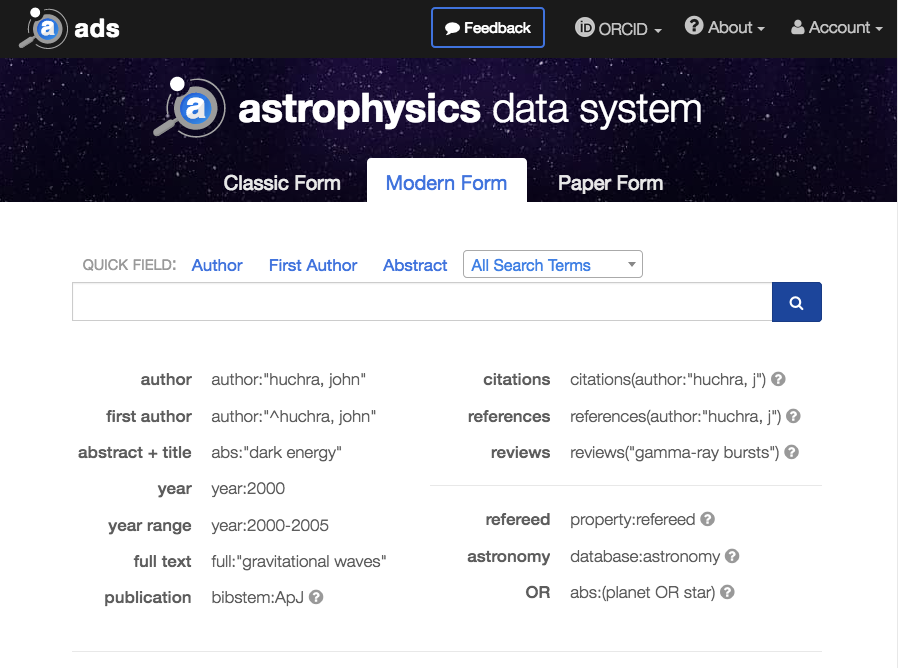

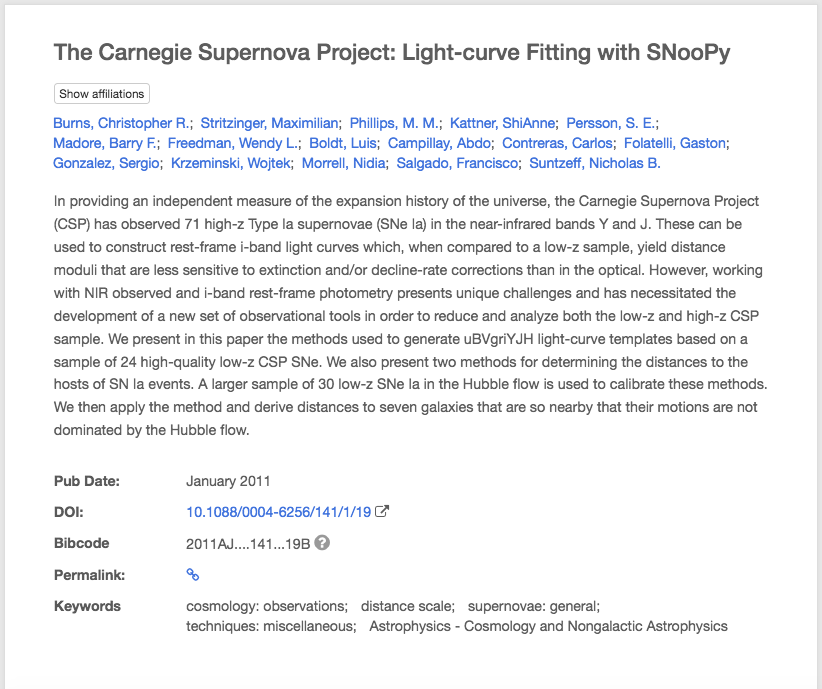

## Getting the keywords

We are using the API given by the Astrophysics Data System, ADS, described at https://github.com/adsabs/adsabs-dev-api.

We loop through each ASCL entry, indexed by the ASCL ID, and grab the bibcode for each paper that cites this code.  We use that bibcode with the ADS API in order to retrieve the keyword entries.



In [21]:
# the dict that will hold the number by journal by year
code_by_journal_year = {}

# some ASCL entries don't have any refs.  Let's track those.
entries_no_refs = []

# +++ some refs need to be looked at later and cleaned
clean_refs_later = []

In [22]:

# create a dict data structure to hold the keywords
ascl_keywords_dict = {}

# now loop through all the entries, to grab the keywords
#for key, val in ascl_data.items():
for x in '0':
    
    # +++
    key = '1403.002'
    val = ascl_data[key]
    
    # initialize the empty keyword list so we can extend it later
    ascl_keywords_dict[key] = list()
    
    print('-------------------------------')
    curr_ascl_record = val
    print('ascl_id: ',curr_ascl_record['ascl_id'])
    list_refs = curr_ascl_record['ref_list']
    print(' --------------')
    
    # grab the year from the ASCL ID
    curr_year = key[:2]
    # we'll hard code in the 2 digit prefix, using 2050 as a safe time
    if int(curr_year) > 50:
        curr_year = '19'+str(curr_year)
    else:
        curr_year = '20'+str(curr_year)
        
    # some entries don't have any refs
    if not list_refs:
        entries_no_refs.append(key)
        continue
        
    for ref in list_refs:
        print(' ref: ',ref)
        
        # ### CLEAN THE REF AND BIBCODE
        # +++ it would be convenient if the bibcode was an entry in the JSON, rather than the ref
        
        # some refs had the URL replacement for an ampersand 
        ref = ref.replace('%26','&')
        
        # if the last character is a slash, remove it
        if ref.endswith('/'):
            ref = ref[:-1]
            
        # just get the last part of the html, to get the bibcode
        last_slash_idx = ref.rfind('/')
        curr_bibcode = ref[last_slash_idx+1:last_slash_idx+1+19]
            
        # check that URL actually does end with the bibcode
        if 'abstract' in curr_bibcode:
            last_slash_idx = ref.rfind('/',0,last_slash_idx)
            curr_bibcode = ref[last_slash_idx+1:last_slash_idx+1+19]
        
        # some refs had the URL replacement for an ampersand 
        curr_bibcode = curr_bibcode.replace('%26','&')
        
        # if the ref is a URL to arxiv, turn it into a usable bibcode
        if 'arxiv.org' in str.lower(ref):
            bibcode_year = curr_bibcode[:2]
            # we'll hard code in the 2 digit prefix, using 2050 as a safe time
            if int(bibcode_year) > 50:
                bibcode_year = '19'+str(bibcode_year)
            else:
                bibcode_year = '20'+str(bibcode_year)

            curr_bibcode = bibcode_year + 'arXiv' + curr_bibcode + 'V'
            curr_bibcode = curr_bibcode.replace('.','')
        
        # some entries need to be cleaned better later
        okay_urls = ['arxiv','adsabs']
        if not any(x in str.lower(ref) for x in okay_urls):
            print("not any")
            #if ('arxiv.org' not in str.lower(ref)) and ('adsabs.org' not in str.lower(ref)):
            clean_refs_later.append(key)
            continue
        
        bibcode = {"bibcode":[curr_bibcode]}
        print(' bibcode: ',bibcode)
        r = requests.post("https://api.adsabs.harvard.edu/v1/export/bibtex", \
                         headers={"Authorization": "Bearer " + token, "Content-type": "application/json"}, \
                         data=json.dumps(bibcode))
        
        # get the journal from the bibcode
        curr_journal=curr_bibcode[4:9]
        curr_journal=curr_journal.strip('.')
        print("--journal=",curr_journal)
        
        # the dict of this json entry
        curr_entry = r.json()
        print(curr_entry)
        curr_entry_info = curr_entry["export"]

        # +++ I would prefer to put all of the fields in a dict, but I couldn't get the regex exactly right yet
        # this grabs the newline, to combine two entries in a row, which is wrong, but close
        # see entry for 1998ApJ...509...39N for an example
        #print(' curr_entry_info: ',curr_entry_info)
        #re.findall(r'(\S+) = (.*\s*.*\,\s)', curr_entry_info)  

        # for now, just grab the keywords
        curr_entry_info_dict = dict(re.findall(r'(keywords) = (.*\s*.*\,\s)', curr_entry_info))
        
        # if there were no keywords in this entry, go to the next entry
        if not curr_entry_info_dict:
            continue
            
        # remove: any newlines in the middle, starting and ending curly braces, multiple spaces in a row
        curr_entry_info_dict['keywords'] = curr_entry_info_dict['keywords'].replace('\n','')
        curr_entry_info_dict['keywords'] = curr_entry_info_dict['keywords'].replace('{','')
        curr_entry_info_dict['keywords'] = curr_entry_info_dict['keywords'].replace('}','')
        curr_entry_info_dict['keywords'] = re.sub(' +',' ', curr_entry_info_dict['keywords'])
        #print('  keywords: ',curr_entry_info_dict['keywords'])
        
        # convert the keywords to a list
        keyword_list = curr_entry_info_dict['keywords'].split(",")
        # and strip the spaces    
        keyword_list = [x.strip(' ') for x in keyword_list]
        # remove the inadvertant empty fields
        keyword_list = filter(None, keyword_list)
        # remove any keywords that are "astrophysics", as that is redundant in the ASCL
        
        # for this ascl_id, record the keywords 
        ascl_keywords_dict[key].extend(keyword_list)

        # add the year and journal to the dict from which we will plot
        # check if the year is already in our 2D dict
        if curr_year in code_by_journal_year:
            if curr_journal in code_by_journal_year[curr_year]:
                code_by_journal_year[curr_year][curr_journal] += 1
            else:
                code_by_journal_year[curr_year][curr_journal] = 1
        else:
            code_by_journal_year[curr_year]={}
            code_by_journal_year[curr_year][curr_journal] = 1
    
    

-------------------------------
ascl_id:  1403.002
 --------------
 ref:  http://adsabs.harvard.edu/abs/2013A%26A...549A...8B
 bibcode:  {'bibcode': ['2013A&A...549A...8B']}
--journal= A&A
{'error': 'Too many requests'}


KeyError: 'export'

In [5]:
# let's put the 2d dict of year-journal entries into a datafram

# +++ turning the 2D dict into a dataframe may be unnecessarily complicating things
code_by_journal_year_df = pd.DataFrame(code_by_journal_year)
code_by_journal_year_df = code_by_journal_year_df.transpose()

# and let's see it
print(code_by_journal_year)


{'2018': {'arXiv1': 1}}


## Incomplete Entries

Some ASCL entries were missing refs.  They are listed here, to go back and fix later

In [6]:
print("Entries without Refs")
print(entries_no_refs)
print("Clean these Refs")
print(clean_refs_later)

Entries without Refs
['1805.024', '1311.008']
Clean these Refs
['1403.002', '1010.063', '1505.033', '1702.004', '1404.002', '1404.002', '1202.013', '1104.003', '1811.013', '1811.013', '1811.013', '1710.021', '1401.009', '1303.030', '1208.006', '1607.005', '1606.006', '1407.014', '1011.013', '1101.002', '1505.006', '1807.011', '1112.016', '1810.007', '1612.004', '1611.017', '1010.064', '1102.021', '1102.022', '1309.007', '1309.007', '1408.020', '1511.022', '1010.035', '1812.008', '1703.014', '1204.004', '1107.013', '1107.013', '1412.005', '1507.017', '1807.009', '1209.012', '1605.002', '1010.014', '1710.016', '1010.027', '1311.010', '1303.012', '1206.012', '1806.021', '1412.011', '1412.011', '1412.011', '1710.012', '1710.012', '1710.012', '1201.004', '1504.011', '1311.005', '1311.005', '1504.014', '1810.015', '1804.022', '1804.022', '1804.022', '1505.007', '1804.016', '1706.005', '1806.019', '1502.023', '1806.024', '1806.024', '1806.024', '1806.024', '1505.002', '1709.004', '1709.004', 

## Plotting the participation by journal

Using the metadata we collected when gathering the keywords, we can track the participation by year by journal. The plots show, by paper publication year, the number of entries from each journal which have a software code registered in the ASCL.
There is a bar for each journal, even if some journals don't have any entries for that year, to make it easier to compare by year the journal participation.

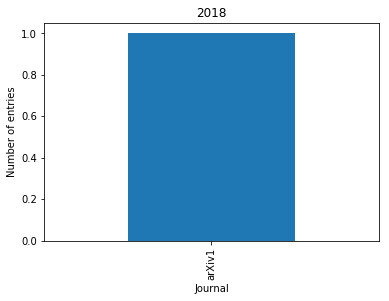

In [7]:

# sort the dataframe by year
code_by_journal_year_df = code_by_journal_year_df.sort_index()

# Plot each year in a separate graph
for year, outerrow in code_by_journal_year_df.iterrows():
    plt.title(year)
    plt.xlabel('Journal')
    plt.ylabel('Number of entries')
    
    outerrow.plot.bar()
    plt.show()
    
# +++ this would be more interesting with a pie chart to show percentages
# also, the y axis should all be integers here

## Saving the keywords

Now that we have all the keywords, save them to a text file.  This will be provided to the ASCL in order to update their records of the each code.

In [8]:
# save the keywords to a file
f = open("ascl_keywords.txt","w")

# write them in the format:
# ascl_id: ['keyword1','keyword2','keyword3']
for key, val in ascl_keywords_dict.items():
    f.write(key)
    f.write(':')
    f.write(str(val))
    f.write("\n")
    
f.close()


In [9]:
# +++ for testing, print the keywords
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(ascl_keywords_dict)

{   '0202.001': [],
    '1010.009': [],
    '1010.014': [],
    '1010.022': [],
    '1010.027': [],
    '1010.029': [],
    '1010.035': [],
    '1010.049': [],
    '1010.063': [],
    '1010.064': [],
    '1010.066': [],
    '1010.069': [],
    '1010.083': [],
    '1010.085': [],
    '1011.008': [],
    '1011.010': [],
    '1011.013': [],
    '1011.015': [],
    '1011.017': [],
    '1101.001': [],
    '1101.002': [],
    '1101.003': [],
    '1101.004': [],
    '1102.004': [],
    '1102.017': [],
    '1102.021': [],
    '1102.022': [],
    '1103.012': [],
    '1103.014': [],
    '1104.003': [],
    '1104.004': [],
    '1105.009': [],
    '1106.009': [],
    '1106.010': [],
    '1106.017': [],
    '1106.019': [],
    '1107.004': [],
    '1107.005': [],
    '1107.012': [],
    '1107.013': [],
    '1108.005': [],
    '1108.010': [],
    '1108.015': [],
    '1108.019': [],
    '1110.001': [],
    '1110.013': [],
    '1110.014': [],
    '1111.002': [],
    '1111.003': [],
    '1111.011': [],
